# Защита персональных данных клиентов

Требуется защитить данные клиентов страховой компании.   
Для этого мы разработаем метод преобразования данных, для усложнения восстановления персональной информации, с обоснованием выбранного метода.  
При этом наше преобразование не ухудшит качество моделей машинного обучения.

## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('/datasets/insurance.csv')

In [3]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
df['Возраст'] = df['Возраст'].astype('int')

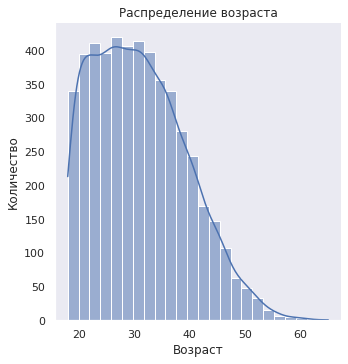

In [6]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.displot(data=df, x='Возраст', kde=True, bins=24)
plt.grid(color='grey', linestyle='-', linewidth=0.8, alpha=0.8)
plt.title('Распределение возраста')
plt.ylabel('Количество')
plt.show()

In [7]:
df['Возраст'].describe()

count    5000.000000
mean       30.952800
std         8.440807
min        18.000000
25%        24.000000
50%        30.000000
75%        37.000000
max        65.000000
Name: Возраст, dtype: float64

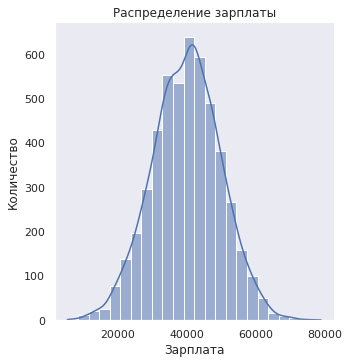

In [8]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.displot(data=df, x='Зарплата', kde=True, bins=24, )
plt.grid(color='grey', linestyle='-', linewidth=0.8, alpha=0.8)
plt.title('Распределение зарплаты')
plt.ylabel('Количество')
plt.show()

In [9]:
df['Зарплата'].describe()

count     5000.000000
mean     39916.360000
std       9900.083569
min       5300.000000
25%      33300.000000
50%      40200.000000
75%      46600.000000
max      79000.000000
Name: Зарплата, dtype: float64

In [10]:
df['Пол'].value_counts()

0    2505
1    2495
Name: Пол, dtype: int64

In [11]:
df['Члены семьи'].value_counts()

1    1814
0    1513
2    1071
3     439
4     124
5      32
6       7
Name: Члены семьи, dtype: int64

In [12]:
df['Страховые выплаты'].value_counts()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: Страховые выплаты, dtype: int64

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Вопрос:** Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?


**Обоснование:**   
Формула обучения:

$$
w_{2} = ((XZ)^T XZ)^{-1} (XZ)^T y 
$$

Расскроем скобки. Для этого воспользуемся следующими свойствами матриц:
1. $(AB)^T=B^TA^T$
2. $(AB)^{-1} = B^{-1}A^{-1}$ - данное равенство верно только для двух квадратных обратимых матриц
3. $AA^{-1}=A^{-1}A=E$, где $E$ - единичная матрица.
4. $AE=EA=A$

$$
w_{2} = (Z^T X^T XZ)^{-1} Z^T X^T y = (X^T (XZ))^{-1} (Z^T)^{-1} Z^T X^T y = Z^{-1} (X^T X)^{-1} X^T y = Z^{-1} w
$$

Предсказания:

$$
a_{2} = X Z w_{2} = X Z Z^{-1} w = X w = a
$$

**Ответ:** Не изменится.


***
Преобразования имеют силу только если матрица признаков обратима.

## Алгоритм преобразования

**Алгоритм**

Имеются данные пользовалелей: $X$.

Преобразуем данные путём умножения матрицы признаков $X$ на обратимую матрицу $Z$. Получим преобразованную матрицу $XZ$.

Обучим модель линейной регрессии на исходных данных: $w = Inv(X) * y$\
Сделаем предсказания на исодных данных: $a = Xw$

Обучим модель на преобразованных данных: $wZ = Inv(Z) * w$\
Сделаем предсказания на преобразованных данных: $a_{2} = X_{2}wP$

**Обоснование**

Если всё правильно, то при преобразовании матрицы путём умножения её на обратимую матрицу, мы можем получить одинаковые результаты на обоих выборках с небольшой погрешностью.

## Проверка алгоритма

Проведем операции согласно алгоритма:

In [13]:
features = df.drop(['Страховые выплаты'], axis='columns').values
target = df['Страховые выплаты'].values

In [14]:
model = LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print('R2-score на исходных данных:', r2_score(target, predictions))

R2-score на исходных данных: 0.4249455028666801


In [15]:
converted_matrix = np.random.RandomState(12345).normal(size = [features.shape[1], features.shape[1]])
converted_matrix_inv = np.linalg.inv(converted_matrix)
converted_features = features.dot(converted_matrix)

In [16]:
model.fit(converted_features, target)
converted_predictions = model.predict(converted_features)
print('R2-score на преобразованных данных:', r2_score(target, converted_predictions))

R2-score на преобразованных данных: 0.42494550286667687


## Вывод

Наш алгоритм преобразования данных для защиты клиентов работает, и выполняет условия поставленной задачи.